In [341]:
import os
import h5py
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
from metrics import calculate_metric
from natsort import natsorted
from evaluate import*
import pandas as pd
import glob

In [342]:
def meanHR(PR,PRlength, HR_len):

    MeanPR = []
    for j in range(0,(PRlength//7)*7,PRlength//HR_len):
        PRmean = np.mean(PR[j:(j+(PRlength//HR_len))])
        MeanPR.append(PRmean)
    return np.array(MeanPR)


In [326]:
patnames[-1]

'/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/phynetNegpea/outputppg_pearson/test_all/NICU/pat_20/part7'

In [345]:
%matplotlib inline
# ppgPath = Path('/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/Diffboundingbox/outputppg/outputppg_pearson_bound_20/test/inter')
ppgPath = Path('/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/phynetNegpea/outputppg_pearson/test_all/NICU')
DATA_DIR='/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/conventionalResult/nicucrop'
GTpath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/Datafolder/nicucrop'
patnames = natsorted(glob.glob(os.path.join(ppgPath, "*pat*/part*")))
col = []
fcol = []
col_pat = []
chromDict = {}
filtDict = {}
HRdict = {}
HRdictfilt = {}
i = 1
plt.figure(figsize=(45,15))
for patpath in (patnames[:]):#+patnames[4:-3]):
#     print(patname)
    patnum, partname = patpath.split('_')[-1].split('/')
    print(patnum, partname)
    patname = os.path.basename('/'.join(patpath.split('/')[:-1])) #os.path.basename(patname)
    vidpath = glob.glob(os.path.join(DATA_DIR,patname,'*/C0C',partname, "*CHROM"))[0]
    prediction = os.path.join(ppgPath,patname,partname, "{}.h5".format('ppgsignal'))
    label = os.path.join(ppgPath,patname,partname, "{}.h5".format('ppgGtsignal'))
    HRgtpath = glob.glob(os.path.join(GTpath,patname,'*/C0C',partname, 'HRgroundtruth.h5'))[0]
    if (Path(vidpath).exists()): 
        fvideo = h5py.File(vidpath, 'r')
        ppg = fvideo['ppg']
        HR = fvideo['HR']      
    if (Path(prediction).exists()):
        fpred = h5py.File(prediction, 'r')
        pred = fpred['ppgsignal']
    if (Path(label).exists()):
        flabel = h5py.File(label, 'r')
        label = flabel['ppgsignal']
    if (Path(HRgtpath).exists()):
        fHR = h5py.File(HRgtpath, 'r')
        HRGt = fHR['HRgt']
# # #     print(len(ppg), len(label),len(pred),len(HRgt))
    HR, HRchromGt, MAE, RMSE, meanSNR = evluate(pred, label,window_size =260, fs = 25, signal = 'pulse')
#     pearson = abs(np.corrcoef(HR, HRchromGt)[1, 0])
    
    PRlength = (len(label)//25)*10
    HR0 = meanHR(HRGt,PRlength,len(HR))
    min_len = min(len(HR), len(HR0))
    HR0 = HR0[:min_len]
    HR = HR[:min_len]
    HRchrom = np.array(HR).squeeze() 
    
    mean,diff,md,sd = bland_altman_params(HR0, HR,i, 10,patnum, partname)

    HRVal = []
    for j in range(len(diff)):
        if diff[j]!=np.nan:
            if abs(diff[j])<(2*sd) :
                HRVal.append([HR[j], HR0[j],HRchromGt[j]])
    if len(HRVal)==0:continue
    else:
        HRValid = np.array(HRVal).transpose(1,0)
        
    MAETrue = np.mean(np.abs(HR - HR0))
    RMSETrue = np.sqrt(np.mean(np.square(HR - HR0)))
    pearsonTrue = abs(np.corrcoef(HR, HR0)[1, 0])
        
    MAEchrom = np.mean(np.abs(HRValid[0] - HRValid[1]))
    RMSEchrom = np.sqrt(np.mean(np.square(HRValid[0] - HRValid[1])))
    pearsonchrom = abs(np.corrcoef(HRValid[0], HRValid[1])[1, 0])
        
    col.append('pat_{}_{}'.format(str(patnum), str(partname)))
    if   'pat_{}_{}'.format(str(patnum),str(partname)) in chromDict:
        chromDict['pat_{}_{}'.format(str(patnum),str(partname))].append([MAETrue,RMSETrue,pearsonTrue,meanSNR])
    else:
        chromDict['pat_{}_{}'.format(str(patnum), str(partname))] = [MAETrue,RMSETrue,pearsonTrue,meanSNR]
        
#     fcol.append('pat_{}_{}'.format(str(patnum), str(partname)))
    

    if 'pat_{}_{}'.format(str(patnum),str(partname)) in filtDict:
            filtDict['pat_{}_{}'.format(str(patnum),str(partname))].append([MAEchrom,RMSEchrom,pearsonchrom])
    else:
        filtDict['pat_{}_{}'.format(str(patnum), str(partname))] = [MAEchrom,RMSEchrom,pearsonchrom]

#     i+=1
    dfchrom = pd.DataFrame(chromDict,index=['MAE','RMSE','PEARSON','SNR'],columns=col)
    dffilt = pd.DataFrame(filtDict,index=['MAE','RMSE','PEARSON'],columns=col)
    
#     print(HR,HR0)
# #     scatter_plot_with_correlation_line(HRGt, HR,i,len(patnames)+1,patnum, partname)
#     bland_altman_plot(HR0, HR,i,len(patnames),patnum, partname)
#     scatter_plot_with_correlation_line(HR0, HR,i,len(patnames),patnum, partname)
    col_pat.append('pat_{}'.format(str(patnum)))   
    if 'pat_{}'.format(str(patnum)) in HRdict:
        HRdict['pat_{}'.format(str(patnum))].append([HR,HR0,HRchromGt]) #[HR[j], HR0[j],HRchromGt[j]
    else:
        HRdict['pat_{}'.format(str(patnum))] =[ [HR,HR0,HRchromGt]]
    if 'pat_{}'.format(str(patnum)) in HRdictfilt:
        HRdictfilt['pat_{}'.format(str(patnum))].append([HRValid])
    else:
        HRdictfilt['pat_{}'.format(str(patnum))] =[[HRValid]]
    i += 1
#     break
# # # #     print(patname,HR,HRGt)
# # #     print('w.r.t GT:', patname,HR,HRGt, MAEgt, RMSEgt, pearsongt)
#     break
# display(dfchrom)
# display(dffilt)

02 part1
02 part2
02 part3
02 part4
02 part5
02 part6
02 part7
06 part1
06 part2
06 part3
06 part4
06 part5
06 part6
06 part7
07 part1
07 part2
07 part3
07 part4
07 part6
07 part7
09 part1
09 part2
09 part3
09 part4
09 part5
09 part6
09 part7
10 part1


/usr/local/python-pkgs/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/python-pkgs/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/python-pkgs/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


10 part2
10 part3
10 part4
10 part5
10 part6
10 part7
11 part1
11 part2
11 part3
11 part4
11 part5
11 part6
11 part7
12 part1
12 part2
12 part3
12 part4
12 part5
12 part6
12 part7
13 part1
13 part2
13 part3
13 part4
13 part5
13 part6
13 part7
14 part1
14 part2
14 part3
14 part4
14 part5
14 part6
14 part7
15 part1
15 part2
15 part3
15 part4
15 part5
15 part6
15 part7
16 part1
16 part2
16 part3
16 part4
16 part5
16 part6
16 part7
19 part2
19 part3
19 part4
19 part6
19 part7
20 part2
20 part3
20 part4
20 part5
20 part6
20 part7


<Figure size 3240x1080 with 0 Axes>

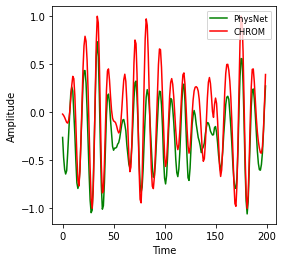

In [334]:
# 2
fig = plt.figure(figsize=(4,4))
plt.plot(pred[:200],'g', label ='PhysNet')#, plt.xlabel('Time'), plt.ylabel=('Amplitude')
plt.plot(label[:200],'r', label ='CHROM'), plt.xlabel('Time'), plt.ylabel('Amplitude')
plt.legend(fontsize = 'small')
fig.savefig(os.path.join(outputfigpath,'{}_ppgextracted_Physnet.png'.format(pat)), bbox_inches='tight')
fig.savefig(os.path.join(outputfigpath,'{}_ppgextracted_Physnet.png'.format(pat)), bbox_inches='tight', dpi=300)

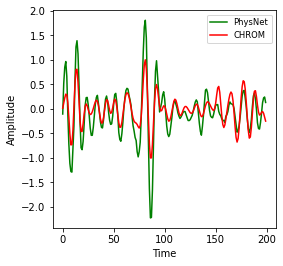

In [267]:
#3
fig = plt.figure(figsize=(4,4))
plt.plot(pred[:200],'g', label ='PhysNet')#, plt.xlabel('Time'), plt.ylabel=('Amplitude')
plt.plot(label[:200],'r', label ='CHROM'), plt.xlabel('Time'), plt.ylabel('Amplitude')
plt.legend(fontsize = 'small')

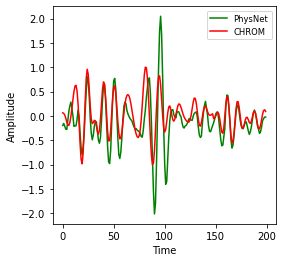

In [269]:
#4
fig = plt.figure(figsize=(4,4))
plt.plot(pred[:200],'g', label ='PhysNet')#, plt.xlabel('Time'), plt.ylabel=('Amplitude')
plt.plot(label[:200],'r', label ='CHROM'), plt.xlabel('Time'), plt.ylabel('Amplitude')
plt.legend(fontsize = 'small')

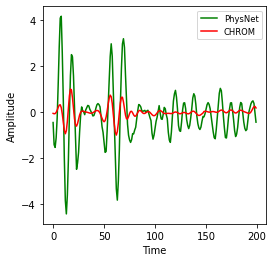

In [272]:
#5
fig = plt.figure(figsize=(4,4))
plt.plot(pred[:200],'g', label ='PhysNet')#, plt.xlabel('Time'), plt.ylabel=('Amplitude')
plt.plot(label[:200],'r', label ='CHROM'), plt.xlabel('Time'), plt.ylabel('Amplitude')
plt.legend(fontsize = 'small')

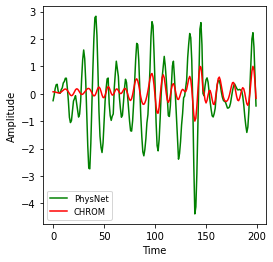

In [274]:
#6
fig = plt.figure(figsize=(4,4))
plt.plot(pred[:200],'g', label ='PhysNet')#, plt.xlabel('Time'), plt.ylabel=('Amplitude')
plt.plot(label[:200],'r', label ='CHROM'), plt.xlabel('Time'), plt.ylabel('Amplitude')
plt.legend(fontsize = 'small')

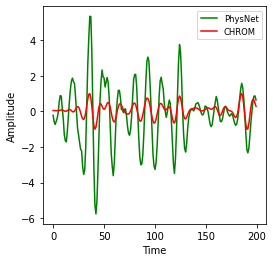

In [276]:
#7
fig = plt.figure(figsize=(4,4))
plt.plot(pred[:200],'g', label ='PhysNet')#, plt.xlabel('Time'), plt.ylabel=('Amplitude')
plt.plot(label[:200],'r', label ='CHROM'), plt.xlabel('Time'), plt.ylabel('Amplitude')
plt.legend(fontsize = 'small')

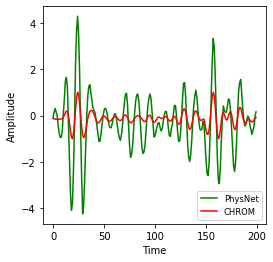

In [507]:
fig = plt.figure(figsize=(4,4))
plt.plot(pred[:200],'g', label ='PhysNet')#, plt.xlabel('Time'), plt.ylabel=('Amplitude')
plt.plot(label[:200],'r', label ='CHROM'), plt.xlabel('Time'), plt.ylabel('Amplitude')
plt.legend(fontsize = 'small')

In [83]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
display(dfchrom)
display(dffilt)

,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,6.771186,8.916286,12.387875,11.494676,12.851423,6.325945,14.830074,11.005161,9.943666,2.437853,6.277923,12.268579,9.386680,8.548294,17.834746,46.291395,14.386082,10.447631,14.813505,14.498153,4.161995,2.688614,4.558344,12.344361,8.206378,26.858214,38.214146,0.703325,0.491688,1.307149,2.823990,0.673837,2.649120,3.046719,10.285419,16.660691,27.397816,17.485984,12.546013,11.516460,12.564646,11.280204,3.736854,12.288733,8.534605,13.267003,7.779009,7.954476,16.169980,22.814917,5.418133,18.696925,8.324587,2.861147,2.274880,4.069372,5.921447,12.476641,8.816493,12.397219,2.425630,3.411397,5.888309,5.019796,3.297153,0.850228
RMSE,10.564896,11.833057,14.342559,13.778579,18.487826,8.075436,17.343305,11.796563,16.744826,3.198181,9.153603,15.587867,11.362275,12.746543,22.563897,72.368457,19.057674,18.136479,16.487699,18.130125,7.024258,3.466797,6.514020,17.850914,10.458203,28.506690,41.965787,0.948066,0.663084,1.537317,4.071217,0.807051,4.221177,4.506806,12.907273,22.648302,31.433647,22.778894,14.336622,15.873379,17.999763,16.489667,6.780068,14.348097,10.758759,14.601053,8.909501,10.579575,19.967913,27.876502,6.943143,25.268561,11.432065,3.021709,2.518490,5.846644,7.815373,15.403781,12.670617,14.852014,2.891731,4.336129,8.456910,7.895288,3.727469,1.075031
PEARSON,0.265411,0.320672,0.541961,0.107129,0.122598,0.255493,0.190074,0.527663,0.029510,0.586484,0.550543,0.450318,0.577710,0.220192,0.294058,0.300703,0.667094,0.970877,0.498770,0.026868,0.156086,0.933440,0.260473,0.064545,0.441674,0.410672,0.446547,0.838568,0.825270,0.888487,0.204621,0.737533,0.079352,0.271715,0.252877,0.484237,0.022516,0.683456,0.309413,0.525658,0.239222,0.552692,0.514396,0.263657,0.665346,0.094635,0.172514,0.294833,0.169646,0.154056,0.449637,0.485981,0.353373,0.865230,0.822159,0.167054,0.524935,0.451539,0.299183,0.291601,0.561177,0.930918,0.309471,0.923307,0.619919,0.793484
SNR,-2.459384,-8.127452,-6.897820,-10.812339,-7.780006,-9.260628,-7.027672,-9.082362,-8.917030,-0.512457,-4.284896,-9.502623,-6.819829,-7.369770,-5.826571,-7.798171,-8.523558,-8.221495,-9.366303,-6.330156,-1.889076,-5.735067,-7.531265,-8.282359,-7.242748,-10.128317,-7.171656,10.331414,6.323303,9.511364,5.443303,3.934072,0.855267,1.065203,-4.699020,-7.320312,-8.743788,-8.013865,-5.175975,-7.430626,-6.429157,-6.722510,-6.233626,-9.941748,-7.262912,-11.205241,-6.035110,-7.849045,-5.049578,-8.814827,-6.712737,-7.454395,-8.023819,2.289606,-4.997854,-2.757751,-7.377385,-4.310853,-4.992850,-5.140911,0.788998,1.374703,0.840766,1.842058,4.673821,3.568665


,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,3.206519,8.916286,12.387875,11.494676,3.678862,4.479205,12.324250,11.005161,3.958540,1.590613,3.603911,8.522621,9.386680,4.742568,13.263103,22.091199,14.386082,3.872881,14.813505,10.439505,1.668905,1.826532,2.779791,7.011930,8.206378,11.999674,22.196762,0.441395,0.296023,1.307149,2.823990,0.673837,1.204498,2.034355,7.582334,11.906975,7.493644,8.672588,12.546013,7.838005,3.582627,6.371904,1.300782,12.288733,8.534605,13.267003,7.779009,5.418579,4.830726,7.444263,3.590417,8.236881,8.324587,2.861147,2.274880,2.240417,3.964276,9.669622,5.689309,12.397219,2.425630,2.273598,3.387288,2.370430,3.297153,0.850228
RMSE,3.600319,11.833057,14.342559,13.778579,4.615554,5.462112,14.534208,11.796563,4.307540,1.834511,4.830892,9.969860,11.362275,6.547663,16.726385,26.216113,19.057674,4.401116,16.487699,12.343155,1.978348,2.150618,3.838293,8.836540,10.458203,11.999674,22.215217,0.517864,0.308915,1.537317,4.071217,0.807051,1.374709,3.350205,9.307049,16.989100,10.117297,12.604740,14.336622,11.110828,4.191087,8.345777,2.119357,14.348097,10.758759,14.601053,8.909501,7.011476,5.973007,9.069330,3.933076,13.131866,11.432065,3.021709,2.518490,2.469242,4.894098,12.006555,8.548062,14.852014,2.891731,2.449284,4.261413,2.840561,3.727469,1.075031
PEARSON,0.053302,0.320672,0.541961,0.107129,0.923610,0.155541,0.046782,0.527663,0.450433,0.885359,0.308779,0.069784,0.577710,0.296223,0.037380,0.737059,0.667094,0.647687,0.498770,0.261248,0.882228,0.982379,0.833440,0.562097,0.441674,NaN,0.989718,0.972832,0.957350,0.888487,0.204621,0.737533,0.896388,0.002917,0.169645,0.247773,1.000000,0.427072,0.309413,0.020392,0.912056,0.030750,0.683830,0.263657,0.665346,0.094635,0.172514,0.502198,0.939930,0.057307,0.823497,0.664916,0.353373,0.865230,0.822159,0.817489,0.809864,0.672947,0.026682,0.291601,0.561177,0.938711,0.760706,0.749014,0.619919,0.793484


In [8]:
#180
pd.set_option("display.max_rows", None, "display.max_columns", None)
display(dfchrom)
display(dffilt)

,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,5.506410,7.151709,10.938034,7.908832,12.701567,6.445869,10.082621,15.955840,11.175214,9.227920,10.939459,10.179487,14.000712,14.768519,15.848291,46.548433,19.051994,23.902422,15.754274,13.386040,6.138889,4.707265,10.631054,13.222222,8.201567,27.487892,29.856838,1.670655,1.605413,2.347578,1.989316,1.497151,3.399573,2.951567,9.889601,18.108974,24.985755,22.176638,12.397436,9.283476,14.372507,10.290598,6.034900,9.349003,9.015670,12.102564,5.097578,8.325499,13.582621,22.750000,11.567664,17.349715,11.361823,8.719373,3.512108,4.670940,13.724359,11.298433,8.235043,14.193732,4.690883,6.838319,10.034188,3.141595,3.045584,1.344729
RMSE,8.435924,8.675179,14.215770,9.271798,16.603447,7.530424,12.714165,19.340074,13.956778,14.162012,17.192922,12.317785,18.209782,18.256859,21.212923,89.792924,22.205018,38.999610,17.904167,17.511422,8.241009,6.997491,17.122311,15.969679,9.473844,29.418271,35.683871,1.772051,1.832439,3.354188,3.194123,1.710259,4.518126,4.519709,12.396290,21.937740,28.546986,26.571386,14.247343,11.893231,19.772098,11.760440,8.519215,12.223589,10.663527,15.958199,6.267430,11.388128,17.296778,29.117349,16.296379,24.552492,17.436896,11.395604,4.076585,6.495292,18.322186,13.793840,11.523891,15.904355,5.675943,10.366739,14.482857,4.014390,3.627942,1.637881
PEARSON,0.508419,0.022352,0.045394,0.033528,0.225685,0.181402,0.221519,0.264773,0.129538,0.077634,0.052935,0.057927,0.000878,0.320891,0.083805,0.049228,0.884601,0.381031,0.201555,0.446661,0.100953,0.673921,0.188803,0.315723,0.215044,0.395129,0.145880,0.671407,0.782842,0.382690,0.460277,0.118664,0.195877,0.190673,0.363301,0.036860,0.048371,0.523774,0.524358,0.246678,0.411083,0.254834,0.184447,0.604816,0.381612,0.455433,0.579674,0.217854,0.241942,0.385956,0.287540,0.614103,0.343889,0.006799,0.652033,0.184133,0.094403,0.146687,0.193979,0.598219,0.395449,0.381225,0.417622,0.627984,0.692251,0.401612
SNR,-4.780499,-8.792997,-9.145644,-7.093143,-6.111215,-7.118211,-3.990211,-9.558948,-9.072978,-4.649338,-1.973484,-11.637232,-7.417434,-7.048800,-9.059682,-8.833876,-9.559492,-10.576008,-8.420164,-7.323382,-5.579475,-5.304514,-9.666443,-7.928590,-8.850175,-9.431632,-7.621380,7.070863,2.720838,7.040545,5.206037,2.210836,1.416509,-0.590953,-4.757733,-5.863093,-7.332423,-7.221477,-5.645202,-6.003459,-8.652547,-10.992916,-5.540578,-6.287281,-9.934799,-14.757858,-7.494286,-10.233494,-3.881695,-9.580637,-5.518507,-6.200472,-6.385377,-1.124647,-7.184205,-3.044536,-8.368603,-6.272814,-6.348707,-5.825716,-0.077156,-3.785351,-1.225179,-1.099250,2.396410,2.782371


,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,3.302885,7.151709,10.938034,7.908832,12.701567,6.445869,10.082621,15.955840,11.175214,9.227920,10.939459,10.179487,14.000712,14.768519,15.848291,46.548433,19.051994,23.902422,15.754274,13.386040,6.138889,4.707265,10.631054,13.222222,8.201567,21.375000,25.405449,1.670655,1.605413,2.347578,1.989316,1.497151,3.399573,2.951567,9.889601,18.108974,22.385417,22.176638,12.397436,9.283476,14.372507,10.290598,6.034900,9.349003,9.015670,12.102564,5.097578,8.325499,13.582621,22.750000,11.567664,17.349715,11.361823,8.719373,3.512108,4.670940,13.724359,11.298433,8.235043,14.193732,4.690883,6.838319,10.034188,3.141595,3.045584,1.344729
RMSE,3.627548,8.675179,14.215770,9.271798,16.603447,7.530424,12.714165,19.340074,13.956778,14.162012,17.192922,12.317785,18.209782,18.256859,21.212923,89.792924,22.205018,38.999610,17.904167,17.511422,8.241009,6.997491,17.122311,15.969679,9.473844,22.211297,29.945775,1.772051,1.832439,3.354188,3.194123,1.710259,4.518126,4.519709,12.396290,21.937740,25.587571,26.571386,14.247343,11.893231,19.772098,11.760440,8.519215,12.223589,10.663527,15.958199,6.267430,11.388128,17.296778,29.117349,16.296379,24.552492,17.436896,11.395604,4.076585,6.495292,18.322186,13.793840,11.523891,15.904355,5.675943,10.366739,14.482857,4.014390,3.627942,1.637881
PEARSON,0.299593,0.022352,0.045394,0.033528,0.225685,0.181402,0.221519,0.264773,0.129538,0.077634,0.052935,0.057927,0.000878,0.320891,0.083805,0.049228,0.884601,0.381031,0.201555,0.446661,0.100953,0.673921,0.188803,0.315723,0.215044,0.892438,0.119111,0.671407,0.782842,0.382690,0.460277,0.118664,0.195877,0.190673,0.363301,0.036860,0.177039,0.523774,0.524358,0.246678,0.411083,0.254834,0.184447,0.604816,0.381612,0.455433,0.579674,0.217854,0.241942,0.385956,0.287540,0.614103,0.343889,0.006799,0.652033,0.184133,0.094403,0.146687,0.193979,0.598219,0.395449,0.381225,0.417622,0.627984,0.692251,0.401612


In [69]:
#180
pd.set_option("display.max_rows", None, "display.max_columns", None)
display(dfchrom)
display(dffilt)

,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,5.506410,7.151709,10.938034,7.908832,12.701567,6.445869,10.082621,15.955840,11.175214,9.227920,10.939459,10.179487,14.000712,14.768519,15.848291,46.548433,19.051994,23.902422,15.754274,13.386040,6.138889,4.707265,10.631054,13.222222,8.201567,27.487892,29.856838,1.670655,1.605413,2.347578,1.989316,1.497151,3.399573,2.951567,9.889601,18.108974,24.985755,22.176638,12.397436,9.283476,14.372507,10.290598,6.034900,9.349003,9.015670,12.102564,5.097578,8.325499,13.582621,22.750000,11.567664,17.349715,11.361823,8.719373,3.512108,4.670940,13.724359,11.298433,8.235043,14.193732,4.690883,6.838319,10.034188,3.141595,3.045584,1.344729
RMSE,8.435924,8.675179,14.215770,9.271798,16.603447,7.530424,12.714165,19.340074,13.956778,14.162012,17.192922,12.317785,18.209782,18.256859,21.212923,89.792924,22.205018,38.999610,17.904167,17.511422,8.241009,6.997491,17.122311,15.969679,9.473844,29.418271,35.683871,1.772051,1.832439,3.354188,3.194123,1.710259,4.518126,4.519709,12.396290,21.937740,28.546986,26.571386,14.247343,11.893231,19.772098,11.760440,8.519215,12.223589,10.663527,15.958199,6.267430,11.388128,17.296778,29.117349,16.296379,24.552492,17.436896,11.395604,4.076585,6.495292,18.322186,13.793840,11.523891,15.904355,5.675943,10.366739,14.482857,4.014390,3.627942,1.637881
PEARSON,0.508419,0.022352,0.045394,0.033528,0.225685,0.181402,0.221519,0.264773,0.129538,0.077634,0.052935,0.057927,0.000878,0.320891,0.083805,0.049228,0.884601,0.381031,0.201555,0.446661,0.100953,0.673921,0.188803,0.315723,0.215044,0.395129,0.145880,0.671407,0.782842,0.382690,0.460277,0.118664,0.195877,0.190673,0.363301,0.036860,0.048371,0.523774,0.524358,0.246678,0.411083,0.254834,0.184447,0.604816,0.381612,0.455433,0.579674,0.217854,0.241942,0.385956,0.287540,0.614103,0.343889,0.006799,0.652033,0.184133,0.094403,0.146687,0.193979,0.598219,0.395449,0.381225,0.417622,0.627984,0.692251,0.401612
SNR,-4.780499,-8.792997,-9.145644,-7.093143,-6.111215,-7.118211,-3.990211,-9.558948,-9.072978,-4.649338,-1.973484,-11.637232,-7.417434,-7.048800,-9.059682,-8.833876,-9.559492,-10.576008,-8.420164,-7.323382,-5.579475,-5.304514,-9.666443,-7.928590,-8.850175,-9.431632,-7.621380,7.070863,2.720838,7.040545,5.206037,2.210836,1.416509,-0.590953,-4.757733,-5.863093,-7.332423,-7.221477,-5.645202,-6.003459,-8.652547,-10.992916,-5.540578,-6.287281,-9.934799,-14.757858,-7.494286,-10.233494,-3.881695,-9.580637,-5.518507,-6.200472,-6.385377,-1.124647,-7.184205,-3.044536,-8.368603,-6.272814,-6.348707,-5.825716,-0.077156,-3.785351,-1.225179,-1.099250,2.396410,2.782371


,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,3.302885,7.151709,10.938034,7.908832,8.118132,5.349359,8.411859,13.017628,9.078526,6.377404,7.264423,9.061699,10.496795,8.382479,12.435897,19.827724,19.051994,13.808494,13.132212,7.699634,3.339744,3.500000,6.310897,13.222222,8.201567,15.508547,17.481838,1.670655,1.605413,1.659455,1.248397,1.497151,1.941392,1.171245,6.283883,15.066506,14.683333,14.818376,8.409188,7.187500,7.311355,10.290598,4.420673,7.016827,9.015670,9.507212,5.097578,6.158654,11.180288,11.299145,5.789377,8.979853,6.976763,6.250000,3.512108,3.607372,10.620192,9.349359,6.056090,14.193732,4.690883,4.254808,6.679487,2.572756,2.489583,1.344729
RMSE,3.627548,8.675179,14.215770,9.271798,10.803038,5.903173,10.636069,15.038007,11.022669,9.867946,11.363727,11.179822,12.337302,10.898309,16.538560,24.498701,22.205018,18.494252,13.855880,8.808921,3.841038,5.412020,8.632911,15.969679,9.473844,15.632955,19.452694,1.772051,1.832439,2.224646,1.908801,1.710259,2.353102,1.472923,7.266208,17.781614,17.371456,19.452841,9.774358,8.619535,8.059841,11.760440,6.063614,8.369485,10.663527,12.307738,6.267430,7.974619,14.215672,14.387684,7.212783,11.988533,8.511170,6.689067,4.076585,5.074452,13.850211,11.120381,8.188580,15.904355,5.675943,5.131045,8.125955,3.276171,2.790694,1.637881
PEARSON,0.299593,0.022352,0.045394,0.033528,0.037646,0.176395,0.307225,0.034668,0.264637,0.001231,0.367105,0.159041,0.444845,0.647506,0.264084,0.022070,0.884601,0.719843,0.037489,0.677769,0.753744,0.822599,0.635484,0.315723,0.215044,0.941099,0.703237,0.671407,0.782842,0.531763,0.839551,0.118664,0.431033,0.788171,0.294521,0.240224,0.139339,0.674540,0.509091,0.053100,0.588067,0.254834,0.337089,0.701138,0.381612,0.408950,0.579674,0.486108,0.057496,0.074782,0.444595,0.214552,0.385098,0.088194,0.652033,0.489689,0.076042,0.348580,0.050949,0.598219,0.395449,0.320428,0.182772,0.184002,0.827207,0.401612


In [6]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
display(dfchrom)
display(dffilt)

,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,5.506410,7.151709,10.938034,7.908832,12.701567,6.445869,10.082621,15.955840,11.175214,9.227920,10.939459,10.179487,14.000712,14.768519,15.848291,46.548433,19.051994,23.902422,15.754274,13.386040,6.138889,4.707265,10.631054,13.222222,8.201567,27.487892,29.856838,1.670655,1.605413,2.347578,1.989316,1.497151,3.399573,2.951567,9.889601,18.108974,24.985755,22.176638,12.397436,9.283476,14.372507,10.290598,6.034900,9.349003,9.015670,12.102564,5.097578,8.325499,13.582621,22.750000,11.567664,17.349715,11.361823,8.719373,3.512108,4.670940,13.724359,11.298433,8.235043,14.193732,4.690883,6.838319,10.034188,3.141595,3.045584,1.344729
RMSE,8.435924,8.675179,14.215770,9.271798,16.603447,7.530424,12.714165,19.340074,13.956778,14.162012,17.192922,12.317785,18.209782,18.256859,21.212923,89.792924,22.205018,38.999610,17.904167,17.511422,8.241009,6.997491,17.122311,15.969679,9.473844,29.418271,35.683871,1.772051,1.832439,3.354188,3.194123,1.710259,4.518126,4.519709,12.396290,21.937740,28.546986,26.571386,14.247343,11.893231,19.772098,11.760440,8.519215,12.223589,10.663527,15.958199,6.267430,11.388128,17.296778,29.117349,16.296379,24.552492,17.436896,11.395604,4.076585,6.495292,18.322186,13.793840,11.523891,15.904355,5.675943,10.366739,14.482857,4.014390,3.627942,1.637881
PEARSON,0.508419,0.022352,0.045394,0.033528,0.225685,0.181402,0.221519,0.264773,0.129538,0.077634,0.052935,0.057927,0.000878,0.320891,0.083805,0.049228,0.884601,0.381031,0.201555,0.446661,0.100953,0.673921,0.188803,0.315723,0.215044,0.395129,0.145880,0.671407,0.782842,0.382690,0.460277,0.118664,0.195877,0.190673,0.363301,0.036860,0.048371,0.523774,0.524358,0.246678,0.411083,0.254834,0.184447,0.604816,0.381612,0.455433,0.579674,0.217854,0.241942,0.385956,0.287540,0.614103,0.343889,0.006799,0.652033,0.184133,0.094403,0.146687,0.193979,0.598219,0.395449,0.381225,0.417622,0.627984,0.692251,0.401612
SNR,-4.780499,-8.792997,-9.145644,-7.093143,-6.111215,-7.118211,-3.990211,-9.558948,-9.072978,-4.649338,-1.973484,-11.637232,-7.417434,-7.048800,-9.059682,-8.833876,-9.559492,-10.576008,-8.420164,-7.323382,-5.579475,-5.304514,-9.666443,-7.928590,-8.850175,-9.431632,-7.621380,7.070863,2.720838,7.040545,5.206037,2.210836,1.416509,-0.590953,-4.757733,-5.863093,-7.332423,-7.221477,-5.645202,-6.003459,-8.652547,-10.992916,-5.540578,-6.287281,-9.934799,-14.757858,-7.494286,-10.233494,-3.881695,-9.580637,-5.518507,-6.200472,-6.385377,-1.124647,-7.184205,-3.044536,-8.368603,-6.272814,-6.348707,-5.825716,-0.077156,-3.785351,-1.225179,-1.099250,2.396410,2.782371


,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,3.302885,7.151709,10.938034,7.908832,12.701567,6.445869,10.082621,15.955840,11.175214,9.227920,10.939459,10.179487,14.000712,14.768519,15.848291,46.548433,19.051994,23.902422,15.754274,13.386040,6.138889,4.707265,10.631054,13.222222,8.201567,21.375000,25.405449,1.670655,1.605413,2.347578,1.989316,1.497151,3.399573,2.951567,9.889601,18.108974,22.385417,22.176638,12.397436,9.283476,14.372507,10.290598,6.034900,9.349003,9.015670,12.102564,5.097578,8.325499,13.582621,22.750000,11.567664,17.349715,11.361823,8.719373,3.512108,4.670940,13.724359,11.298433,8.235043,14.193732,4.690883,6.838319,10.034188,3.141595,3.045584,1.344729
RMSE,3.627548,8.675179,14.215770,9.271798,16.603447,7.530424,12.714165,19.340074,13.956778,14.162012,17.192922,12.317785,18.209782,18.256859,21.212923,89.792924,22.205018,38.999610,17.904167,17.511422,8.241009,6.997491,17.122311,15.969679,9.473844,22.211297,29.945775,1.772051,1.832439,3.354188,3.194123,1.710259,4.518126,4.519709,12.396290,21.937740,25.587571,26.571386,14.247343,11.893231,19.772098,11.760440,8.519215,12.223589,10.663527,15.958199,6.267430,11.388128,17.296778,29.117349,16.296379,24.552492,17.436896,11.395604,4.076585,6.495292,18.322186,13.793840,11.523891,15.904355,5.675943,10.366739,14.482857,4.014390,3.627942,1.637881
PEARSON,0.299593,0.022352,0.045394,0.033528,0.225685,0.181402,0.221519,0.264773,0.129538,0.077634,0.052935,0.057927,0.000878,0.320891,0.083805,0.049228,0.884601,0.381031,0.201555,0.446661,0.100953,0.673921,0.188803,0.315723,0.215044,0.892438,0.119111,0.671407,0.782842,0.382690,0.460277,0.118664,0.195877,0.190673,0.363301,0.036860,0.177039,0.523774,0.524358,0.246678,0.411083,0.254834,0.184447,0.604816,0.381612,0.455433,0.579674,0.217854,0.241942,0.385956,0.287540,0.614103,0.343889,0.006799,0.652033,0.184133,0.094403,0.146687,0.193979,0.598219,0.395449,0.381225,0.417622,0.627984,0.692251,0.401612


In [426]:
pred.shape

(1776,)

In [85]:
!ls /home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/Diagrams/

11_SQIdiagraam.png  diffROI_07.png  diffROI_19.png
diffROI_06.png	    diffROI_13.png


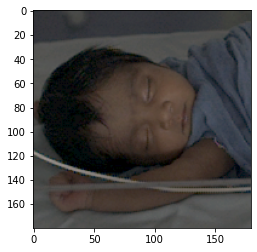

In [255]:
fig = plt.figure(figsize=(4,4))
facecrop_10_path = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/Datafolder/nicucrop/pat_03/f02_01/C0C/part1/'
facecrop_10 = h5py.File (Path(facecrop_10_path,'facecrop_10.h5'),'r')
faces_10 = facecrop_10['facecrop'][:]
plt.imshow(faces_10[1000])
# fig.savefig('/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/FinalDiagrams/croppedfaces_03_10_300dpi.png', bbox_inches='tight', dpi=300)
# fig.savefig('/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/FinalDiagrams/croppedfaces_03_10.png', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.plot(pred[1300:],'g', label ='Physnel')#, plt.xlabel('Time'), plt.ylabel=('Amplitude')
plt.plot(label[1300:],'r', label ='Chrom'), plt.xlabel('Time'), plt.ylabel('Amplitude')
plt.legend(fontsize = 'small')
# outputpath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/FinalDiagrams/'
# fig.savefig('/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/FinalDiagrams/extractedppg_20.png')

In [ ]:
fig = plt.figure(figsize=(4,4))
plt.plot(pred[:200],'g', label ='PhysNet')#, plt.xlabel('Time'), plt.ylabel=('Amplitude')
plt.plot(label[:200],'r', label ='CHROM'), plt.xlabel('Time'), plt.ylabel('Amplitude')
plt.legend(fontsize = 'small')
outputpath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/FinalDiagrams/'
# fig.savefig('/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/FinalDiagrams/extractedppg_20_300dpi.png', bbox_inches='tight', dpi=300)

In [24]:
metricsFilePath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/phynetNegpea/metrics/final/all_180'
os.makedirs(metricsFilePath, exist_ok=True)
chromMetrics = metricsFilePath +'/chromMetrics.csv'
dfchrom.to_csv(chromMetrics,index = False)
chromMetricsfiltered = metricsFilePath +'/chromMetricsfiltered.csv'
dffilt.to_csv(chromMetricsfiltered,index = False)

In [26]:
# display(dfchrom)
# display(dffilt)

In [346]:
def scatter_plot_with_correlation_line(x, y,patnum):
    # Create scatter plot
    
#     xx = np.linspace(90,220,20)
#     yy = np.linspace(90,220,20)
#     plt.subplot(2,n,i+n).plot(xx, yy)
    plt.scatter(x, y, marker ='o',color ='b')

#     # Add correlation line
    axes = plt.gca()
    m, b = np.polyfit(x, y, 1)
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
#     plt.subplot(n//2,n-(n//2),i)
#     plt.legend([])
    print('slope:',m,b)
    plt.plot(X_plot, m*X_plot + b,'-', color ='blue', label='Best fitted line')
    plt.legend()
    
#     plt.xlim(90,220)
#     plt.ylim(90,220)
#     plt.title(patnum)
    plt.show()
    
def bland_altman_params(data1, data2,i,n,patnum,partname, *args, **kwargs):
#     data = []
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0) 
    return mean,diff,md,sd
    
def bland_altman_plot(data1, data2,i,n,patnum,partname, *args, **kwargs):
#     data = []
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    
#     for i in range(diff.shape[0]):
#         if (md - 1.96*sd<diff[i] and diff[i] <md + 1.96*sd):
#             data.append([data1[i],data2[i]])
    plt.subplot(2,n,i).scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + sd, color='gray', linestyle='--')#1.96
    plt.axhline(md - sd, color='gray', linestyle='--')
#     plt.title('{}_{}'.format(patnum,partname))
#     return np.array(data), md, sd
def bland_altman_plot_patwise(data1, data2,patnum, *args, **kwargs):
#     data = []
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    
#     for i in range(diff.shape[0]):
#         if (md - 1.96*sd<diff[i] and diff[i] <md + 1.96*sd):
#             data.append([data1[i],data2[i]])
    print('md,sd:',md,sd)
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + sd, color='gray', linestyle='--')#1.96
    
    x = [142, 142,142]#[129.5, 129.5,129.5]
    y = [md,md+sd,md-sd]
    for i, j in zip(x, y):
       plt.text(i, j, '{} (bpm)'.format(round(j,3)))
    plt.axhline(md - sd, color='gray', linestyle='--')
    plt.xlabel('mean(refHR,predHR)(bpm)')
    plt.ylabel('Diff(refHR,predHR)(bpm)')
#     plt.title('{}'.format(patnum))
    
def scatter_plot_with_correlation_line_patwise(x, y,patnum):
    # Create scatter plot
            xx = np.linspace(100,150,20)
            yy = np.linspace(100,150,20)
#             plt.scatter(x, y,color='yellow', label ='Outlier points')
            plt.plot(xx, yy,color='y', linestyle='--', label = 'Ideal line')
            plt.xlabel('Reference HR (bpm)')
            plt.ylabel('Predicted HR (bpm)')
            plt.legend( fontsize = 'small')

In [347]:
newlist = list()
for i in HRdictfilt.keys():
    newlist.append(i)

In [348]:
newlist[4:]

['pat_10',
 'pat_11',
 'pat_12',
 'pat_13',
 'pat_14',
 'pat_15',
 'pat_16',
 'pat_19',
 'pat_20']

In [353]:
HR0tot, HRtot, HRchrtot = [], [],[]
patno = 12
for i, pat in enumerate(newlist[patno:]):
#     print(pat)
    HRarr = HRdict[pat]
    for k in range(len(HRarr)):
            HRtot.append(HRarr[k][0])
            HR0tot.append(HRarr[k][1])
            HRchrtot.append(HRarr[k][2])
    break
HR0toarr = (np.array(HR0tot)).flatten()
HRtoarr = (np.array(HRtot)).flatten()
HRchrtoarr = (np.array(HRchrtot)).flatten()
HR0totfilt, HRtotfilt, HRchrtotfilt = [], [], []
for i, pat in enumerate(newlist[patno:]):
    HRarr = HRdictfilt[pat]
    for k in range(len(HRarr)):#[HR[j], HR0[j],HRchromGt[j]
            HRtotfilt.append(HRarr[k][0][0])
            HR0totfilt.append( HRarr[k][0][1])
            HRchrtotfilt.append( HRarr[k][0][2])
    break
HR0toarrfilt = [item for sublist in HR0totfilt  for item in sublist] 
HRtoarrfilt = [item for sublist in HRtotfilt  for item in sublist] 
HRchrtoarrfilt = [item for sublist in HRchrtotfilt  for item in sublist] 
pat
# outputpath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/FinalDiagrams/'

'pat_20'

md,sd: 1.569250688106636 5.184808783022005


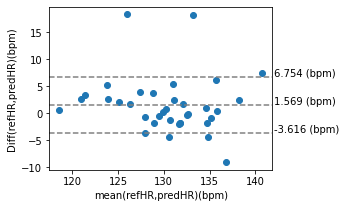

In [233]:
outputfigpath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/FinalDiagrams/'
# /home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/Diagrams/
os.makedirs(outputfigpath, exist_ok=True)
fig = plt.figure(figsize=(4,3))
bland_altman_plot_patwise(HR0toarr,HRtoarr,pat)
# fig.savefig(os.path.join(outputfigpath,'{}_ba.png'.format(pat)),bbox_inches='tight')   

slope: 0.8658122261481241 16.653623095093987


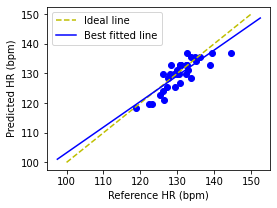

pat_20


In [354]:
fig = plt.figure(figsize=(4,3))
scatter_plot_with_correlation_line_patwise(HR0toarr,HRtoarr,pat)
scatter_plot_with_correlation_line(HR0toarrfilt,HRtoarrfilt,pat)
print(pat)
fig.savefig(os.path.join(outputfigpath,'{}_corr_simple.png'.format(pat)), bbox_inches='tight')

slope: 0.8517404124534003 17.8067036358492


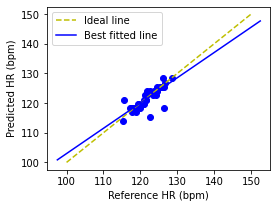

pat_12


In [352]:
fig = plt.figure(figsize=(4,3))
scatter_plot_with_correlation_line_patwise(HR0toarr,HRtoarr,pat)
scatter_plot_with_correlation_line(HR0toarrfilt,HRtoarrfilt,pat)
print(pat)
fig.savefig(os.path.join(outputfigpath,'{}_corr_simple.png'.format(pat)), bbox_inches='tight')

In [384]:
# 0.86x+16:pat:20

In [99]:
# outputfigpath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/Results/physnetnegpea_260/{}'.format(pat)
# os.makedirs(outputfigpath, exist_ok=True)
# with h5py.File(Path(outputfigpath,'HRphysnet.h5'), 'w') as hf:
#     hf.create_dataset('HR', data=HRtoarr, maxshape=(None,), chunks=True)
#     hf.create_dataset('HR0', data=HR0toarr, maxshape=(None,), chunks=True)
#     hf.create_dataset('HRchrom', data=HRchrtoarr, maxshape=(None,), chunks=True)
#     hf.create_dataset('HRfilt', data=HRtoarrfilt, maxshape=(None,), chunks=True)
#     hf.create_dataset('HR0filt', data=HR0toarrfilt, maxshape=(None,), chunks=True)
#     hf.create_dataset('HRchromfilt', data=HRchrtoarrfilt, maxshape=(None,), chunks=True)
    

md,sd: 0.8767689937181607 2.893253153012452


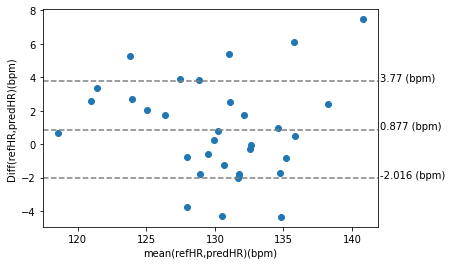

In [355]:
%matplotlib inline
fig = plt.figure()
bland_altman_plot_patwise(HR0toarrfilt,HRtoarrfilt,pat)
    #nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/Results
# fig.savefig(os.path.join(outputfigpath,'{}_ba_filtered.png'.format(pat)), bbox_inches='tight')

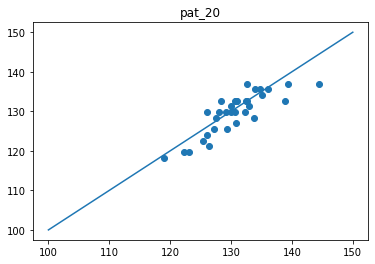

In [101]:
 %matplotlib inline
fig = plt.figure()
scatter_plot_with_correlation_line_patwise(HR0toarrfilt,HRtoarrfilt,pat)
# outputfigpath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/Results/physnetNegpea_260/'
# os.makedirs(outputfigpath, exist_ok=True)
# fig.savefig(os.path.join(outputfigpath,'{}_corr_filtered.png'.format(pat)), bbox_inches='tight')

In [223]:
os.path.join(outputfigpath,'pat06_corr_filtered.png')

'/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/Results/physnetNegpea_260/pat06_corr_filtered.png'

In [23]:
display(dfchrom)
display(dffilt)

,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,5.506410,7.151709,10.938034,7.908832,12.701567,6.445869,10.082621,15.955840,11.175214,9.227920,10.939459,10.179487,14.000712,14.768519,15.848291,46.548433,19.051994,23.902422,15.754274,13.386040,6.138889,4.707265,10.631054,13.222222,8.201567,27.487892,29.856838,1.670655,1.605413,2.347578,1.989316,1.497151,3.399573,2.951567,9.889601,18.108974,24.985755,22.176638,12.397436,9.283476,14.372507,10.290598,6.034900,9.349003,9.015670,12.102564,5.097578,8.325499,13.582621,22.750000,11.567664,17.349715,11.361823,8.719373,3.512108,4.670940,13.724359,11.298433,8.235043,14.193732,4.690883,6.838319,10.034188,3.141595,3.045584,1.344729
RMSE,8.435924,8.675179,14.215770,9.271798,16.603447,7.530424,12.714165,19.340074,13.956778,14.162012,17.192922,12.317785,18.209782,18.256859,21.212923,89.792924,22.205018,38.999610,17.904167,17.511422,8.241009,6.997491,17.122311,15.969679,9.473844,29.418271,35.683871,1.772051,1.832439,3.354188,3.194123,1.710259,4.518126,4.519709,12.396290,21.937740,28.546986,26.571386,14.247343,11.893231,19.772098,11.760440,8.519215,12.223589,10.663527,15.958199,6.267430,11.388128,17.296778,29.117349,16.296379,24.552492,17.436896,11.395604,4.076585,6.495292,18.322186,13.793840,11.523891,15.904355,5.675943,10.366739,14.482857,4.014390,3.627942,1.637881
PEARSON,0.508419,0.022352,0.045394,0.033528,0.225685,0.181402,0.221519,0.264773,0.129538,0.077634,0.052935,0.057927,0.000878,0.320891,0.083805,0.049228,0.884601,0.381031,0.201555,0.446661,0.100953,0.673921,0.188803,0.315723,0.215044,0.395129,0.145880,0.671407,0.782842,0.382690,0.460277,0.118664,0.195877,0.190673,0.363301,0.036860,0.048371,0.523774,0.524358,0.246678,0.411083,0.254834,0.184447,0.604816,0.381612,0.455433,0.579674,0.217854,0.241942,0.385956,0.287540,0.614103,0.343889,0.006799,0.652033,0.184133,0.094403,0.146687,0.193979,0.598219,0.395449,0.381225,0.417622,0.627984,0.692251,0.401612
SNR,-4.780499,-8.792997,-9.145644,-7.093143,-6.111215,-7.118211,-3.990211,-9.558948,-9.072978,-4.649338,-1.973484,-11.637232,-7.417434,-7.048800,-9.059682,-8.833876,-9.559492,-10.576008,-8.420164,-7.323382,-5.579475,-5.304514,-9.666443,-7.928590,-8.850175,-9.431632,-7.621380,7.070863,2.720838,7.040545,5.206037,2.210836,1.416509,-0.590953,-4.757733,-5.863093,-7.332423,-7.221477,-5.645202,-6.003459,-8.652547,-10.992916,-5.540578,-6.287281,-9.934799,-14.757858,-7.494286,-10.233494,-3.881695,-9.580637,-5.518507,-6.200472,-6.385377,-1.124647,-7.184205,-3.044536,-8.368603,-6.272814,-6.348707,-5.825716,-0.077156,-3.785351,-1.225179,-1.099250,2.396410,2.782371


,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,3.302885,7.151709,10.938034,7.908832,12.701567,6.445869,10.082621,15.955840,11.175214,9.227920,10.939459,10.179487,14.000712,14.768519,15.848291,46.548433,19.051994,23.902422,15.754274,13.386040,6.138889,4.707265,10.631054,13.222222,8.201567,21.375000,25.405449,1.670655,1.605413,2.347578,1.989316,1.497151,3.399573,2.951567,9.889601,18.108974,22.385417,22.176638,12.397436,9.283476,14.372507,10.290598,6.034900,9.349003,9.015670,12.102564,5.097578,8.325499,13.582621,22.750000,11.567664,17.349715,11.361823,8.719373,3.512108,4.670940,13.724359,11.298433,8.235043,14.193732,4.690883,6.838319,10.034188,3.141595,3.045584,1.344729
RMSE,3.627548,8.675179,14.215770,9.271798,16.603447,7.530424,12.714165,19.340074,13.956778,14.162012,17.192922,12.317785,18.209782,18.256859,21.212923,89.792924,22.205018,38.999610,17.904167,17.511422,8.241009,6.997491,17.122311,15.969679,9.473844,22.211297,29.945775,1.772051,1.832439,3.354188,3.194123,1.710259,4.518126,4.519709,12.396290,21.937740,25.587571,26.571386,14.247343,11.893231,19.772098,11.760440,8.519215,12.223589,10.663527,15.958199,6.267430,11.388128,17.296778,29.117349,16.296379,24.552492,17.436896,11.395604,4.076585,6.495292,18.322186,13.793840,11.523891,15.904355,5.675943,10.366739,14.482857,4.014390,3.627942,1.637881
PEARSON,0.299593,0.022352,0.045394,0.033528,0.225685,0.181402,0.221519,0.264773,0.129538,0.077634,0.052935,0.057927,0.000878,0.320891,0.083805,0.049228,0.884601,0.381031,0.201555,0.446661,0.100953,0.673921,0.188803,0.315723,0.215044,0.892438,0.119111,0.671407,0.782842,0.382690,0.460277,0.118664,0.195877,0.190673,0.363301,0.036860,0.177039,0.523774,0.524358,0.246678,0.411083,0.254834,0.184447,0.604816,0.381612,0.455433,0.579674,0.217854,0.241942,0.385956,0.287540,0.614103,0.343889,0.006799,0.652033,0.184133,0.094403,0.146687,0.193979,0.598219,0.395449,0.381225,0.417622,0.627984,0.692251,0.401612


In [26]:
display(dfchrom)
display(dffilt)

,pat_06_part5,pat_06_part7,pat_06_part6,pat_06_part3,pat_02_part2,pat_07_part3,pat_07_part4,pat_20_part7,pat_20_part6,pat_20_part3,pat_11_part7,pat_16_part7,pat_16_part3,pat_16_part4,pat_03_part5,pat_03_part4,pat_19_part7,pat_19_part6,pat_19_part4,pat_09_part4
MAE,12.268579,8.548294,9.386680,2.437853,8.916286,14.386082,10.447631,0.850228,3.297153,3.411397,38.214146,2.274880,5.418133,18.696925,40.185517,40.392764,12.397219,8.816493,12.476641,22.910365
RMSE,15.587867,12.746543,11.362275,3.198181,11.833057,19.057674,18.136479,1.075031,3.727469,4.336129,41.965787,2.518490,6.943143,25.268561,45.980592,43.332536,14.852014,12.670617,15.403781,29.686686
PEARSON,0.450318,0.220192,0.577710,0.586484,0.320672,0.667094,0.970877,0.793484,0.619919,0.930918,0.446547,0.822159,0.449637,0.485981,0.313312,0.202836,0.291601,0.299183,0.451539,0.116457


,pat_06_part5,pat_06_part7,pat_06_part6,pat_06_part3,pat_02_part2,pat_07_part3,pat_07_part4,pat_20_part7,pat_20_part6,pat_20_part3,pat_11_part7,pat_16_part7,pat_16_part3,pat_16_part4,pat_03_part5,pat_03_part4,pat_19_part7,pat_19_part6,pat_19_part4,pat_09_part4
MAE,8.522621,4.742568,9.386680,1.590613,8.916286,14.386082,3.872881,0.850228,3.297153,2.273598,22.196762,2.274880,3.590417,8.236881,26.469932,20.129400,12.397219,5.689309,9.669622,17.213885
RMSE,9.969860,6.547663,11.362275,1.834511,11.833057,19.057674,4.401116,1.075031,3.727469,2.449284,22.215217,2.518490,3.933076,13.131866,29.165310,20.351054,14.852014,8.548062,12.006555,23.006868
PEARSON,0.069784,0.296223,0.577710,0.885359,0.320672,0.667094,0.647687,0.793484,0.619919,0.938711,0.989718,0.822159,0.823497,0.664916,0.150275,1.000000,0.291601,0.026682,0.672947,0.217444


In [380]:
display(dfchrom)
display(dffilt)

,pat_12_part5,pat_12_part2,pat_12_part7,pat_12_part6,pat_12_part3,pat_12_part1,pat_12_part4,pat_14_part5,pat_14_part2,pat_14_part7,pat_14_part6,pat_14_part3,pat_14_part1,pat_14_part4
MAE,0.673837,0.491688,3.046719,2.649120,1.307149,0.703325,2.823990,13.267003,3.736854,7.954476,7.779009,12.288733,11.280204,8.534605
RMSE,0.807051,0.663084,4.506806,4.221177,1.537317,0.948066,4.071217,14.601053,6.780068,10.579575,8.909501,14.348097,16.489667,10.758759
PEARSON,0.737533,0.825270,0.271715,0.079352,0.888487,0.838568,0.204621,0.094635,0.514396,0.294833,0.172514,0.263657,0.552692,0.665346


,pat_12_part5,pat_12_part2,pat_12_part7,pat_12_part6,pat_12_part3,pat_12_part1,pat_12_part4,pat_14_part5,pat_14_part2,pat_14_part7,pat_14_part6,pat_14_part3,pat_14_part1,pat_14_part4
MAE,0.673837,0.296023,2.034355,1.204498,1.307149,0.441395,2.823990,13.267003,1.300782,5.418579,7.779009,12.288733,6.371904,8.534605
RMSE,0.807051,0.308915,3.350205,1.374709,1.537317,0.517864,4.071217,14.601053,2.119357,7.011476,8.909501,14.348097,8.345777,10.758759
PEARSON,0.737533,0.957350,0.002917,0.896388,0.888487,0.972832,0.204621,0.094635,0.683830,0.502198,0.172514,0.263657,0.030750,0.665346


In [33]:
display(dfchrom)
display(dffilt)

,pat_12_part5,pat_12_part2,pat_12_part7,pat_12_part6,pat_12_part3,pat_12_part1,pat_12_part4,pat_14_part5,pat_14_part2,pat_14_part7,pat_14_part6,pat_14_part3,pat_14_part1,pat_14_part4
MAE,0.673837,0.491688,3.046719,2.649120,1.307149,0.703325,2.823990,13.267003,3.736854,7.954476,7.779009,12.288733,11.280204,8.534605
RMSE,0.807051,0.663084,4.506806,4.221177,1.537317,0.948066,4.071217,14.601053,6.780068,10.579575,8.909501,14.348097,16.489667,10.758759
PEARSON,0.737533,0.825270,0.271715,0.079352,0.888487,0.838568,0.204621,0.094635,0.514396,0.294833,0.172514,0.263657,0.552692,0.665346


,pat_12_part5,pat_12_part2,pat_12_part7,pat_12_part6,pat_12_part3,pat_12_part1,pat_12_part4,pat_14_part5,pat_14_part2,pat_14_part7,pat_14_part6,pat_14_part3,pat_14_part1,pat_14_part4
MAE,0.673837,0.296023,2.034355,1.204498,1.307149,0.441395,2.823990,13.267003,1.300782,5.418579,7.779009,12.288733,6.371904,8.534605
RMSE,0.807051,0.308915,3.350205,1.374709,1.537317,0.517864,4.071217,14.601053,2.119357,7.011476,8.909501,14.348097,8.345777,10.758759
PEARSON,0.737533,0.957350,0.002917,0.896388,0.888487,0.972832,0.204621,0.094635,0.683830,0.502198,0.172514,0.263657,0.030750,0.665346


In [32]:
display(dfchrom)
display(dffilt)

,pat_06_part5,pat_06_part7,pat_06_part6,pat_06_part3,pat_02_part2,pat_07_part4,pat_20_part7
MAE,12.268579,8.548294,9.386680,2.437853,8.916286,10.447631,0.850228
RMSE,15.587867,12.746543,11.362275,3.198181,11.833057,18.136479,1.075031
PEARSON,0.450318,0.220192,0.577710,0.586484,0.320672,0.970877,0.793484


,pat_06_part5,pat_06_part7,pat_06_part6,pat_06_part3,pat_02_part2,pat_07_part4,pat_20_part7
MAE,8.522621,4.742568,9.386680,1.590613,8.916286,3.872881,0.850228
RMSE,9.969860,6.547663,11.362275,1.834511,11.833057,4.401116,1.075031
PEARSON,0.069784,0.296223,0.577710,0.885359,0.320672,0.647687,0.793484


In [30]:
display(dfchrom)
display(dffilt)


,pat_06_part5,pat_06_part7,pat_06_part6,pat_06_part3,pat_02_part2,pat_07_part4,pat_20_part7
MAE,18.408927,16.276435,14.610876,6.989626,7.666762,18.643877,3.173318
RMSE,20.953680,22.038140,17.843111,9.039366,9.804912,33.603584,5.410746
PEARSON,0.105843,0.335861,0.187541,0.014246,0.257720,0.502878,0.396524


,pat_06_part5,pat_06_part7,pat_06_part6,pat_06_part3,pat_02_part2,pat_07_part4,pat_20_part7
MAE,13.345994,12.843845,14.610876,5.024336,6.619362,11.154791,1.933578
RMSE,14.452969,16.260331,17.843111,6.436736,8.450121,17.437155,2.499497
PEARSON,0.474787,0.348253,0.187541,0.228547,0.435360,0.119468,0.011450


In [28]:
display(dfchrom)
display(dffilt)

,pat_06_part5,pat_06_part7,pat_06_part6,pat_06_part3,pat_02_part2,pat_07_part3,pat_07_part4,pat_20_part7,pat_20_part6,pat_20_part3,pat_11_part7,pat_16_part7,pat_16_part3,pat_16_part4,pat_03_part5,pat_03_part4,pat_19_part7,pat_19_part6,pat_19_part4,pat_09_part4
MAE,12.268579,8.548294,9.386680,2.437853,8.916286,14.386082,10.447631,0.850228,3.297153,3.411397,38.214146,2.274880,5.418133,18.696925,40.185517,40.392764,12.397219,8.816493,12.476641,22.910365
RMSE,15.587867,12.746543,11.362275,3.198181,11.833057,19.057674,18.136479,1.075031,3.727469,4.336129,41.965787,2.518490,6.943143,25.268561,45.980592,43.332536,14.852014,12.670617,15.403781,29.686686
PEARSON,0.450318,0.220192,0.577710,0.586484,0.320672,0.667094,0.970877,0.793484,0.619919,0.930918,0.446547,0.822159,0.449637,0.485981,0.313312,0.202836,0.291601,0.299183,0.451539,0.116457


,pat_06_part5,pat_06_part7,pat_06_part6,pat_06_part3,pat_02_part2,pat_07_part3,pat_07_part4,pat_20_part7,pat_20_part6,pat_20_part3,pat_11_part7,pat_16_part7,pat_16_part3,pat_16_part4,pat_03_part5,pat_03_part4,pat_19_part7,pat_19_part6,pat_19_part4,pat_09_part4
MAE,8.522621,4.742568,9.386680,1.590613,8.916286,14.386082,3.872881,0.850228,3.297153,2.273598,22.196762,2.274880,3.590417,8.236881,26.469932,20.129400,12.397219,5.689309,9.669622,17.213885
RMSE,9.969860,6.547663,11.362275,1.834511,11.833057,19.057674,4.401116,1.075031,3.727469,2.449284,22.215217,2.518490,3.933076,13.131866,29.165310,20.351054,14.852014,8.548062,12.006555,23.006868
PEARSON,0.069784,0.296223,0.577710,0.885359,0.320672,0.667094,0.647687,0.793484,0.619919,0.938711,0.989718,0.822159,0.823497,0.664916,0.150275,1.000000,0.291601,0.026682,0.672947,0.217444


In [21]:
metricsFilePath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/phynetNegpea/metrics/all_260'
os.makedirs(metricsFilePath, exist_ok=True)

In [22]:
metricsFilePath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/phynetNegpea/metrics/all_260'
os.makedirs(metricsFilePath, exist_ok=True)
chromMetrics = metricsFilePath +'/chromMetrics.csv'
dfchrom.to_csv(chromMetrics,index = False)
chromMetricsfiltered = metricsFilePath +'/chromMetricsfiltered.csv'
dffilt.to_csv(chromMetricsfiltered,index = False)

In [27]:
display(dfchrom)
display(dffilt)

,pat_06_part5,pat_06_part7,pat_06_part6,pat_06_part3,pat_02_part2,pat_07_part3,pat_07_part4,pat_20_part7,pat_20_part6,pat_20_part3,pat_11_part7,pat_16_part7,pat_16_part3,pat_16_part4,pat_03_part5,pat_03_part4,pat_19_part7,pat_19_part6,pat_19_part4,pat_09_part4
MAE,12.268579,8.548294,9.386680,2.437853,8.916286,14.386082,10.447631,0.850228,3.297153,3.411397,38.214146,2.274880,5.418133,18.696925,40.185517,40.392764,12.397219,8.816493,12.476641,22.910365
RMSE,15.587867,12.746543,11.362275,3.198181,11.833057,19.057674,18.136479,1.075031,3.727469,4.336129,41.965787,2.518490,6.943143,25.268561,45.980592,43.332536,14.852014,12.670617,15.403781,29.686686
PEARSON,0.450318,0.220192,0.577710,0.586484,0.320672,0.667094,0.970877,0.793484,0.619919,0.930918,0.446547,0.822159,0.449637,0.485981,0.313312,0.202836,0.291601,0.299183,0.451539,0.116457


,pat_06_part5,pat_06_part7,pat_06_part6,pat_06_part3,pat_02_part2,pat_07_part3,pat_07_part4,pat_20_part7,pat_20_part6,pat_20_part3,pat_11_part7,pat_16_part7,pat_16_part3,pat_16_part4,pat_03_part5,pat_03_part4,pat_19_part7,pat_19_part6,pat_19_part4,pat_09_part4
MAE,8.522621,4.742568,9.386680,1.590613,8.916286,14.386082,3.872881,0.850228,3.297153,2.273598,22.196762,2.274880,3.590417,8.236881,26.469932,20.129400,12.397219,5.689309,9.669622,17.213885
RMSE,9.969860,6.547663,11.362275,1.834511,11.833057,19.057674,4.401116,1.075031,3.727469,2.449284,22.215217,2.518490,3.933076,13.131866,29.165310,20.351054,14.852014,8.548062,12.006555,23.006868
PEARSON,0.069784,0.296223,0.577710,0.885359,0.320672,0.667094,0.647687,0.793484,0.619919,0.938711,0.989718,0.822159,0.823497,0.664916,0.150275,1.000000,0.291601,0.026682,0.672947,0.217444


# NEW

In [277]:
%matplotlib inline
# ppgPath = Path('/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/Diffboundingbox/outputppg/outputppg_pearson_bound_20/test/inter')
ppgPath = Path('/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/phynetNegpea/outputppg_pearson_new/test_all/NICU')
DATA_DIR='/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/conventionalResult/nicucrop'
GTpath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/ConventionalMethod/Whitebalance/Datafolder/nicucrop'
patnames = natsorted(glob.glob(os.path.join(ppgPath, "*pat*/part*")))
col = []
fcol = []
col_pat = []
chromDict = {}
filtDict = {}
HRdict = {}
HRdictfilt = {}
i = 1
plt.figure(figsize=(45,15))
for patpath in (patnames):#+patnames[4:-3]):
#     print(patname)
    patnum, partname = patpath.split('_')[-1].split('/')
#     print(patnum, partname)
    patname = os.path.basename('/'.join(patpath.split('/')[:-1])) #os.path.basename(patname)
    vidpath = glob.glob(os.path.join(DATA_DIR,patname,'*/C0C',partname, "*CHROM*"))[0]
    prediction = os.path.join(ppgPath,patname,partname, "{}.h5".format('ppgsignal'))
    label = os.path.join(ppgPath,patname,partname, "{}.h5".format('ppgGtsignal'))
    HRgtpath = glob.glob(os.path.join(GTpath,patname,'*/C0C',partname, 'HRgroundtruth.h5'))[0]
    if (Path(vidpath).exists()): 
        fvideo = h5py.File(vidpath, 'r')
        ppg = fvideo['ppg']
        HR = fvideo['HR']      
    if (Path(prediction).exists()):
        fpred = h5py.File(prediction, 'r')
        pred = fpred['ppgsignal']
    if (Path(label).exists()):
        flabel = h5py.File(label, 'r')
        label = flabel['ppgsignal']
    if (Path(HRgtpath).exists()):
        fHR = h5py.File(HRgtpath, 'r')
        HRGt = fHR['HRgt']
# # #     print(len(ppg), len(label),len(pred),len(HRgt))
    HR, HRchromGt, MAE, RMSE, meanSNR = evluate(pred, label,window_size =260, fs = 25, signal = 'pulse')
#     pearson = abs(np.corrcoef(HR, HRchromGt)[1, 0])
    
    PRlength = (len(label)//25)*10
    HR0 = meanHR(HRGt,PRlength,len(HR))
    min_len = min(len(HR), len(HR0))
    HR0 = HR0[:min_len]
    HR = HR[:min_len]
    HRchrom = np.array(HR).squeeze() 
    
    mean,diff,md,sd = bland_altman_params(HR0, HR,i, 10,patnum, partname)

    HRVal = []
    for j in range(len(diff)):
        if diff[j]!=np.nan:
            if abs(diff[j])<(2*sd) :
                HRVal.append([HR[j], HR0[j],HRchromGt[j]])
    if len(HRVal)==0:continue
    else:
        HRValid = np.array(HRVal).transpose(1,0)
        
    MAETrue = np.mean(np.abs(HR - HR0))
    RMSETrue = np.sqrt(np.mean(np.square(HR - HR0)))
    pearsonTrue = abs(np.corrcoef(HR, HR0)[1, 0])
        
    MAEchrom = np.mean(np.abs(HRValid[0] - HRValid[1]))
    RMSEchrom = np.sqrt(np.mean(np.square(HRValid[0] - HRValid[1])))
    pearsonchrom = abs(np.corrcoef(HRValid[0], HRValid[1])[1, 0])
        
    col.append('pat_{}_{}'.format(str(patnum), str(partname)))
    if   'pat_{}_{}'.format(str(patnum),str(partname)) in chromDict:
        chromDict['pat_{}_{}'.format(str(patnum),str(partname))].append([MAETrue,RMSETrue,pearsonTrue,meanSNR])
    else:
        chromDict['pat_{}_{}'.format(str(patnum), str(partname))] = [MAETrue,RMSETrue,pearsonTrue,meanSNR]
        
#     fcol.append('pat_{}_{}'.format(str(patnum), str(partname)))
    

    if 'pat_{}_{}'.format(str(patnum),str(partname)) in filtDict:
            filtDict['pat_{}_{}'.format(str(patnum),str(partname))].append([MAEchrom,RMSEchrom,pearsonchrom])
    else:
        filtDict['pat_{}_{}'.format(str(patnum), str(partname))] = [MAEchrom,RMSEchrom,pearsonchrom]

#     i+=1
    dfchrom = pd.DataFrame(chromDict,index=['MAE','RMSE','PEARSON','SNR'],columns=col)
    dffilt = pd.DataFrame(filtDict,index=['MAE','RMSE','PEARSON'],columns=col)
    
#     print(HR,HR0)
# #     scatter_plot_with_correlation_line(HRGt, HR,i,len(patnames)+1,patnum, partname)
#     bland_altman_plot(HR0, HR,i,len(patnames),patnum, partname)
#     scatter_plot_with_correlation_line(HR0, HR,i,len(patnames),patnum, partname)
    col_pat.append('pat_{}'.format(str(patnum)))   
    if 'pat_{}'.format(str(patnum)) in HRdict:
        HRdict['pat_{}'.format(str(patnum))].append([HR,HR0,HRchromGt]) #[HR[j], HR0[j],HRchromGt[j]
    else:
        HRdict['pat_{}'.format(str(patnum))] =[ [HR,HR0,HRchromGt]]
    if 'pat_{}'.format(str(patnum)) in HRdictfilt:
        HRdictfilt['pat_{}'.format(str(patnum))].append([HRValid])
    else:
        HRdictfilt['pat_{}'.format(str(patnum))] =[[HRValid]]
    i += 1
#     break
# # # #     print(patname,HR,HRGt)
# # #     print('w.r.t GT:', patname,HR,HRGt, MAEgt, RMSEgt, pearsongt)
#     break
# display(dfchrom)
# display(dffilt)

/usr/local/python-pkgs/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/python-pkgs/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/python-pkgs/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/python-pkgs/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/python-pkgs/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<Figure size 3240x1080 with 0 Axes>

In [278]:
newlist = list()
for i in HRdictfilt.keys():
    newlist.append(i)

In [299]:
newlist[6]

'pat_12'

In [301]:

# outputpath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/FinalDiagrams/'

'pat_12'

In [313]:
def scatter_plot_with_correlation_line(x, y,patnum):
    # Create scatter plot
    
#     xx = np.linspace(90,220,20)
#     yy = np.linspace(90,220,20)
#     plt.subplot(2,n,i+n).plot(xx, yy)
    plt.scatter(x, y, marker ='o',color ='b')

#     # Add correlation line
    axes = plt.gca()
    m, b = np.polyfit(x, y, 1)
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
#     plt.subplot(n//2,n-(n//2),i)
#     plt.legend([])
    print('slope:',m,b)
    plt.plot(X_plot, m*X_plot + b,'-', color ='blue', label='Best fitted line')
    plt.legend()
    
#     plt.xlim(90,220)
#     plt.ylim(90,220)
#     plt.title(patnum)
    plt.show()
    
def bland_altman_params(data1, data2,i,n,patnum,partname, *args, **kwargs):
#     data = []
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0) 
    return mean,diff,md,sd
    
def bland_altman_plot(data1, data2,i,n,patnum,partname, *args, **kwargs):
#     data = []
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    
#     for i in range(diff.shape[0]):
#         if (md - 1.96*sd<diff[i] and diff[i] <md + 1.96*sd):
#             data.append([data1[i],data2[i]])
    plt.subplot(2,n,i).scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + sd, color='gray', linestyle='--')#1.96
    plt.axhline(md - sd, color='gray', linestyle='--')
#     plt.title('{}_{}'.format(patnum,partname))
#     return np.array(data), md, sd
def bland_altman_plot_patwise(data1, data2,patnum, *args, **kwargs):
#     data = []
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    
#     for i in range(diff.shape[0]):
#         if (md - 1.96*sd<diff[i] and diff[i] <md + 1.96*sd):
#             data.append([data1[i],data2[i]])
    print('md,sd:',md,sd)
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + sd, color='gray', linestyle='--')#1.96
    
    x = [148, 148,148]#[129.5, 129.5,129.5]
    y = [md,md+sd,md-sd]
    for i, j in zip(x, y):
       plt.text(i, j, '{} (bpm)'.format(round(j,3)))
    plt.axhline(md - sd, color='gray', linestyle='--')
#     plt.xlabel('mean(refHR,predHR)(bpm)')
#     plt.ylabel('Diff(refHR,predHR)(bpm)')
#     plt.title('{}'.format(patnum))
    
def scatter_plot_with_correlation_line_patwise(x, y,patnum):
    # Create scatter plot
            xx = np.linspace(100,150,20)
            yy = np.linspace(100,150,20)
            plt.scatter(x, y,color='yellow', label ='Outlier points')
            plt.plot(xx, yy,color='y', linestyle='--', label = 'Ideal line')
#             plt.xlabel('Reference HR (bpm)')
#             plt.ylabel('Predicted HR (bpm)')
            plt.legend( fontsize = 'small')

In [318]:
HR0tot, HRtot, HRchrtot = [], [],[]
patno = 12
for i, pat in enumerate(newlist[patno:]):
#     print(pat)
    HRarr = HRdict[pat]
    for k in range(len(HRarr)):
            HRtot.append(HRarr[k][0])
            HR0tot.append(HRarr[k][1])
            HRchrtot.append(HRarr[k][2])
    break
HR0toarr = (np.array(HR0tot)).flatten()
HRtoarr = (np.array(HRtot)).flatten()
HRchrtoarr = (np.array(HRchrtot)).flatten()
HR0totfilt, HRtotfilt, HRchrtotfilt = [], [], []
for i, pat in enumerate(newlist[patno:]):
    HRarr = HRdictfilt[pat]
    for k in range(len(HRarr)):#[HR[j], HR0[j],HRchromGt[j]
            HRtotfilt.append(HRarr[k][0][0])
            HR0totfilt.append( HRarr[k][0][1])
            HRchrtotfilt.append( HRarr[k][0][2])
    break
HR0toarrfilt = [item for sublist in HR0totfilt  for item in sublist] 
HRtoarrfilt = [item for sublist in HRtotfilt  for item in sublist] 
HRchrtoarrfilt = [item for sublist in HRchrtotfilt  for item in sublist] 
pat

'pat_20'

pat_12
md,sd: 0.5679767378027996 2.5802103624100257


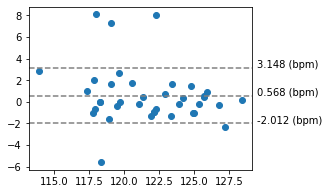

In [307]:
outputfigpath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/FinalDiagrams_2/'
# /home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/Diagrams/
os.makedirs(outputfigpath, exist_ok=True)
fig = plt.figure(figsize=(4,3))
print(pat)
bland_altman_plot_patwise(HR0toarrfilt,HRtoarrfilt,pat)
fig.savefig(os.path.join(outputfigpath,'{}_ba_filtered.png'.format(pat)), bbox_inches='tight')
fig.savefig(os.path.join(outputfigpath,'{}_ba_filtered_300dpi.png'.format(pat)), bbox_inches='tight', dpi=300)

pat_20
slope: 1.115686547357393 -15.562487309242291


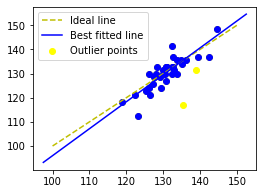

In [319]:
fig = plt.figure(figsize=(4,3))
print(pat)
scatter_plot_with_correlation_line_patwise(HR0toarr,HRtoarr,pat)
scatter_plot_with_correlation_line(HR0toarrfilt,HRtoarrfilt,pat)
# fig.savefig(os.path.join(outputfigpath,'{}_corr.png'.format(pat)), bbox_inches='tight')
fig.savefig(os.path.join(outputfigpath,'{}_corr_300.png'.format(pat)), bbox_inches='tight', dpi=300)

md,sd: 0.4317393971930523 3.533979798794037


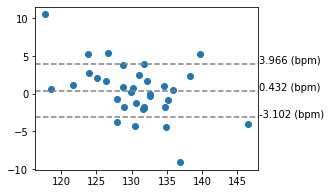

In [311]:
outputfigpath = '/home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/FinalDiagrams_2/'
# /home/nicky/nickynicu/Video-Based-Physiological-Measurement/deeplearning/EMBC/Diagrams/
os.makedirs(outputfigpath, exist_ok=True)
fig = plt.figure(figsize=(4,3))
bland_altman_plot_patwise(HR0toarrfilt,HRtoarrfilt,pat)
fig.savefig(os.path.join(outputfigpath,'{}_ba_filtered.png'.format(pat)), bbox_inches='tight')
fig.savefig(os.path.join(outputfigpath,'{}_ba_filtered_300dpi.png'.format(pat)), bbox_inches='tight', dpi=300)

In [305]:
pat

'pat_12'

In [260]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
display(dfchrom)
display(dffilt)

,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_04_part2,pat_04_part3,pat_04_part4,pat_04_part5,pat_04_part6,pat_04_part7,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_10_part2,pat_10_part3,pat_10_part4,pat_10_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_15_part1,pat_15_part2,pat_15_part3,pat_15_part4,pat_15_part5,pat_15_part6,pat_15_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,11.156888,11.462190,11.494676,19.341808,6.325945,12.666612,54.457030,39.914765,52.789385,14.750489,14.495871,7.048186,10.184050,2.678238,6.277923,12.508963,8.184757,11.545089,9.511951,41.002934,19.193774,11.933399,16.015428,14.257768,18.092080,21.176880,33.509452,19.562853,4.402379,3.904824,3.163679,13.698120,9.944698,27.819752,38.454531,0.803987,0.732073,1.066764,2.823990,3.318068,2.889505,3.287103,19.987831,25.955508,26.139831,12.305628,11.756845,12.324261,8.063777,13.486691,6.371143,10.769013,13.287701,10.347675,24.756084,36.699533,39.530965,30.724468,13.105443,24.408627,37.278412,15.689211,23.165309,6.620056,16.855878,14.814972,2.861147,2.444752,3.348218,7.604140,8.687473,6.893416,9.272219,2.425630,4.372936,5.561006,2.615950,3.584963,0.850228
RMSE,15.394852,13.540220,14.351962,24.744256,7.988705,14.508360,57.995442,43.018349,56.446855,18.022356,22.007020,9.481262,16.792726,3.459323,9.153603,15.616474,10.760036,14.787301,13.663071,70.363217,22.812910,18.851537,18.478758,18.041203,25.136024,29.783431,36.076117,25.958038,7.164099,5.104104,5.143697,18.915355,11.486459,30.024967,42.092969,1.021771,0.938720,1.298155,4.071217,5.920787,4.338229,4.552618,24.304085,30.142410,30.296263,14.216605,15.917449,17.627223,12.658399,18.174804,8.530951,13.173835,15.935504,12.054245,26.216104,39.856289,40.933293,32.725465,15.372604,25.488155,39.534289,19.543758,30.259244,8.691808,23.924755,19.397235,3.021709,2.566671,5.088196,10.147586,11.068352,11.155970,11.963642,2.891731,5.883976,8.197513,3.023356,4.153068,1.075031
PEARSON,0.389530,0.548713,0.109540,0.011809,0.340263,0.076877,0.308365,0.398358,0.576602,0.362399,0.694638,0.738474,0.012327,0.511167,0.550543,0.444740,0.638756,0.147021,0.479814,0.004684,0.656680,0.770829,0.681205,0.008210,0.469948,0.610097,0.389272,0.150330,0.159301,0.773319,0.549684,0.065418,0.567107,0.014078,0.442637,0.829562,0.725247,0.920911,0.204621,0.226246,0.172303,0.328696,0.775323,0.122340,0.724381,0.284395,0.525734,0.232650,0.478670,0.469784,0.059344,0.144000,0.546958,0.188624,0.089186,0.327914,0.220987,0.449762,0.567139,0.378330,0.547557,0.132435,0.196030,0.576969,0.241937,0.631327,0.865230,0.832623,0.339806,0.650875,0.681871,0.150533,0.165184,0.561177,0.862447,0.614790,0.738787,0.587208,0.793484
SNR,-7.846957,-6.783377,-10.561197,-8.446388,-10.051349,-6.260839,-8.396899,-8.588476,-9.840929,-7.730376,-7.264240,-6.846126,-9.064371,-1.431788,-5.949970,-9.622009,-7.497046,-8.323752,-6.012788,-7.355196,-9.674369,-7.686729,-8.668811,-5.582342,-7.328598,-8.373476,-10.772090,-6.977232,-2.086648,-8.350847,-8.121289,-9.190722,-5.962383,-7.515089,-7.638932,10.364894,6.988174,9.127302,5.459741,3.152228,1.011371,0.628578,-6.504657,-9.603881,-7.907510,-5.999162,-9.013278,-8.342431,-5.285608,-8.954991,-7.239486,-9.543115,-6.416939,-7.035066,-9.052431,-13.096245,-6.457033,-11.331272,-4.341064,-13.084649,-7.319652,-5.815548,-7.774757,-7.438611,-10.166178,-7.216969,2.666689,-5.569618,-3.059701,-8.270586,-5.244218,-5.12053

,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_04_part2,pat_04_part3,pat_04_part4,pat_04_part5,pat_04_part6,pat_04_part7,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_10_part2,pat_10_part3,pat_10_part4,pat_10_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_15_part1,pat_15_part2,pat_15_part3,pat_15_part4,pat_15_part5,pat_15_part6,pat_15_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,11.156888,11.462190,8.371904,10.363266,4.479205,10.752412,20.324967,20.181551,18.257171,10.400522,7.320795,4.321904,4.247001,2.678238,3.603911,8.811082,8.184757,8.338722,5.164863,15.745046,19.193774,5.655802,16.015428,10.151043,12.252868,13.427640,26.481584,9.717813,1.957366,3.904824,1.394654,8.636441,7.287239,14.402053,22.677532,0.562190,0.550587,1.066764,2.823990,1.158344,1.492960,3.287103,19.987831,12.741199,14.060517,12.305628,8.126467,3.582627,4.439570,8.546089,4.078618,10.769013,13.287701,10.347675,14.704694,27.856503,20.555085,15.916558,9.930183,14.46382,14.290743,4.349957,12.407187,6.620056,10.074576,10.121773,2.861147,2.444752,1.663494,2.983132,6.239896,3.093155,9.272219,2.425630,4.372936,2.994524,2.615950,2.790939,0.850228
RMSE,15.394852,13.540220,10.009995,14.774514,5.306860,12.397125,20.324967,20.742528,18.257171,11.104577,8.585926,4.726951,4.525775,3.459323,4.830892,10.023438,10.760036,10.502370,5.360550,18.542683,22.812910,7.148994,18.478758,12.185802,17.633777,18.609360,28.632504,15.501961,2.508943,5.104104,1.704959,11.182445,9.026405,14.790363,22.691351,0.665137,0.720999,1.298155,4.071217,1.486835,1.758435,4.552618,24.304085,15.754846,19.297921,14.216605,11.186229,4.191087,7.426521,10.232183,4.870719,13.173835,15.935504,12.054245,14.704694,30.064476,20.555085,16.006547,10.751373,14.46382,14.290743,5.561707,19.276596,8.691808,13.096135,12.586375,3.021709,2.566671,1.830969,3.451855,7.709473,3.903780,11.963642,2.891731,5.883976,3.602154,3.023356,3.046589,1.075031
PEARSON,0.389530,0.548713,0.095951,0.864485,0.332779,0.179610,NaN,1.000000,NaN,0.350553,0.075246,0.979137,0.376881,0.511167,0.308779,0.069261,0.638756,0.242065,0.797453,0.057179,0.656680,0.149330,0.681205,0.289544,0.056338,0.371471,0.128453,0.026328,0.818301,0.773319,0.941750,0.421308,0.914329,1.000000,0.974611,0.916711,0.824491,0.920911,0.204621,0.488634,0.909473,0.328696,0.775323,0.999527,0.454972,0.284395,0.024959,0.912056,0.471157,0.342259,0.422569,0.144000,0.546958,0.188624,NaN,0.042860,NaN,NaN,0.126390,NaN,NaN,0.965878,0.637212,0.576969,0.568379,0.443480,0.865230,0.832623,0.890668,0.708044,0.617151,0.634757,0.165184,0.561177,0.862447,0.915561,0.738787,0.753485,0.793484


In [516]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
display(dfchrom)
display(dffilt)

,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_09_part1,pat_09_part2,pat_09_part3,pat_09_part4,pat_09_part5,pat_09_part6,pat_10_part1,pat_10_part2,pat_10_part3,pat_10_part4,pat_10_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_15_part1,pat_15_part2,pat_15_part3,pat_15_part4,pat_15_part5,pat_15_part6,pat_15_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,6.771186,8.916286,12.387875,11.494676,12.851423,6.325945,14.830074,11.005161,9.943666,2.437853,6.277923,12.268579,9.386680,8.548294,17.834746,46.291395,14.386082,10.447631,14.813505,14.498153,16.755215,9.707410,23.103542,22.910365,41.321925,20.816873,34.565950,18.092080,27.460778,35.192145,27.255161,4.161995,2.688614,4.558344,12.344361,8.206378,26.858214,38.214146,0.703325,0.491688,1.307149,2.823990,0.673837,2.649120,3.046719,10.285419,16.660691,27.397816,17.485984,12.546013,11.516460,12.564646,11.280204,3.736854,12.288733,8.534605,13.267003,7.779009,7.954476,32.448392,23.574533,32.800196,33.435843,13.586213,27.533627,34.393796,16.169980,22.814917,5.418133,18.696925,8.324587,2.861147,2.274880,4.069372,5.921447,12.476641,8.816493,12.397219,2.425630,3.411397,5.888309,5.019796,3.297153,0.850228
RMSE,10.564896,11.833057,14.342559,13.778579,18.487826,8.075436,17.343305,11.796563,16.744826,3.198181,9.153603,15.587867,11.362275,12.746543,22.563897,72.368457,19.057674,18.136479,16.487699,18.130125,22.156207,18.626700,29.924544,29.686686,44.633363,27.135413,36.512692,25.136024,33.649860,38.183816,32.370735,7.024258,3.466797,6.514020,17.850914,10.458203,28.506690,41.965787,0.948066,0.663084,1.537317,4.071217,0.807051,4.221177,4.506806,12.907273,22.648302,31.433647,22.778894,14.336622,15.873379,17.999763,16.489667,6.780068,14.348097,10.758759,14.601053,8.909501,10.579575,34.557323,26.266426,35.252562,36.302490,15.719932,31.563372,36.601474,19.967913,27.876502,6.943143,25.268561,11.432065,3.021709,2.518490,5.846644,7.815373,15.403781,12.670617,14.852014,2.891731,4.336129,8.456910,7.895288,3.727469,1.075031
PEARSON,0.265411,0.320672,0.541961,0.107129,0.122598,0.255493,0.190074,0.527663,0.029510,0.586484,0.550543,0.450318,0.577710,0.220192,0.294058,0.300703,0.667094,0.970877,0.498770,0.026868,0.617772,0.055210,0.040729,0.116457,0.220983,0.579682,0.330871,0.469948,0.320792,0.587039,0.004536,0.156086,0.933440,0.260473,0.064545,0.441674,0.410672,0.446547,0.838568,0.825270,0.888487,0.204621,0.737533,0.079352,0.271715,0.252877,0.484237,0.022516,0.683456,0.309413,0.525658,0.239222,0.552692,0.514396,0.263657,0.665346,0.094635,0.172514,0.294833,0.231373,0.600893,0.602158,0.611161,0.540933,0.569206,0.798608,0.169646,0.154056,0.449637,0.485981,0.353373,0.865230,0.822159,0.167054,0.524935,0.451539,0.299183,0.291601,0.561177,0.930918,0.309471,0.923307,0.619919,0.793484
SNR,-2.459384,-8.127452,-6.897820,-10.812339,-7.780006,-9.260628,-7.027672,-9.082362,-8.917030,-0.512457,-4.284896,-9.502623,-6.819829,-7.369770,-5.826571,-7.798171,-8.523558,-8.221495,-9.366303,-6.330156,-9.892283,-6.521443,-3.953201,-9.574794,-6.652167,-7.982491,-10.573039,-7.179155,-9.048164,-10.051783,-7.612007,-1.889076,-5.735067,-7.531265,-8.282359,-7.242748,-10.128317,-7.171656,10.331414,6.323303,9.511364,5.443303,3.934072,0.855267,1.065203,-4.699020,-7.320312,-8.743788,-8.013865,-5.175975,-7.430626,-6.42

,pat_02_part1,pat_02_part2,pat_02_part3,pat_02_part4,pat_02_part5,pat_02_part6,pat_02_part7,pat_06_part1,pat_06_part2,pat_06_part3,pat_06_part4,pat_06_part5,pat_06_part6,pat_06_part7,pat_07_part1,pat_07_part2,pat_07_part3,pat_07_part4,pat_07_part6,pat_07_part7,pat_09_part1,pat_09_part2,pat_09_part3,pat_09_part4,pat_09_part5,pat_09_part6,pat_10_part1,pat_10_part2,pat_10_part3,pat_10_part4,pat_10_part7,pat_11_part1,pat_11_part2,pat_11_part3,pat_11_part4,pat_11_part5,pat_11_part6,pat_11_part7,pat_12_part1,pat_12_part2,pat_12_part3,pat_12_part4,pat_12_part5,pat_12_part6,pat_12_part7,pat_13_part1,pat_13_part2,pat_13_part3,pat_13_part4,pat_13_part5,pat_13_part6,pat_13_part7,pat_14_part1,pat_14_part2,pat_14_part3,pat_14_part4,pat_14_part5,pat_14_part6,pat_14_part7,pat_15_part1,pat_15_part2,pat_15_part3,pat_15_part4,pat_15_part5,pat_15_part6,pat_15_part7,pat_16_part1,pat_16_part2,pat_16_part3,pat_16_part4,pat_16_part5,pat_16_part6,pat_16_part7,pat_19_part2,pat_19_part3,pat_19_part4,pat_19_part6,pat_19_part7,pat_20_part2,pat_20_part3,pat_20_part4,pat_20_part5,pat_20_part6,pat_20_part7
MAE,3.206519,8.916286,12.387875,11.494676,3.678862,4.479205,12.324250,11.005161,3.958540,1.590613,3.603911,8.522621,9.386680,4.742568,13.263103,22.091199,14.386082,3.872881,14.813505,10.439505,11.596349,2.711278,11.199478,17.213885,26.289928,9.393823,22.551825,12.252868,20.968318,22.247066,12.545089,1.668905,1.826532,2.779791,7.011930,8.206378,11.999674,22.196762,0.441395,0.296023,1.307149,2.823990,0.673837,1.204498,2.034355,7.582334,11.906975,7.493644,8.672588,12.546013,7.838005,3.582627,6.371904,1.300782,12.288733,8.534605,13.267003,7.779009,5.418579,18.655476,23.574533,18.348598,3.08605,10.507106,13.800739,12.848435,4.830726,7.444263,3.590417,8.236881,8.324587,2.861147,2.274880,2.240417,3.964276,9.669622,5.689309,12.397219,2.425630,2.273598,3.387288,2.370430,3.297153,0.850228
RMSE,3.600319,11.833057,14.342559,13.778579,4.615554,5.462112,14.534208,11.796563,4.307540,1.834511,4.830892,9.969860,11.362275,6.547663,16.726385,26.216113,19.057674,4.401116,16.487699,12.343155,15.065998,4.115824,15.468377,23.006868,26.312197,12.273286,22.551825,17.633777,25.310485,24.424994,17.885893,1.978348,2.150618,3.838293,8.836540,10.458203,11.999674,22.215217,0.517864,0.308915,1.537317,4.071217,0.807051,1.374709,3.350205,9.307049,16.989100,10.117297,12.604740,14.336622,11.110828,4.191087,8.345777,2.119357,14.348097,10.758759,14.601053,8.909501,7.011476,19.069228,26.266426,18.707880,3.08605,11.338041,15.643446,12.848435,5.973007,9.069330,3.933076,13.131866,11.432065,3.021709,2.518490,2.469242,4.894098,12.006555,8.548062,14.852014,2.891731,2.449284,4.261413,2.840561,3.727469,1.075031
PEARSON,0.053302,0.320672,0.541961,0.107129,0.923610,0.155541,0.046782,0.527663,0.450433,0.885359,0.308779,0.069784,0.577710,0.296223,0.037380,0.737059,0.667094,0.647687,0.498770,0.261248,0.406804,0.168851,0.998597,0.217444,1.000000,0.806583,NaN,0.056338,0.073205,0.163545,0.013852,0.882228,0.982379,0.833440,0.562097,0.441674,NaN,0.989718,0.972832,0.957350,0.888487,0.204621,0.737533,0.896388,0.002917,0.169645,0.247773,1.000000,0.427072,0.309413,0.020392,0.912056,0.030750,0.683830,0.263657,0.665346,0.094635,0.172514,0.502198,1.000000,0.600893,1.000000,NaN,0.130226,0.145669,NaN,0.939930,0.057307,0.823497,0.664916,0.353373,0.865230,0.822159,0.817489,0.809864,0.672947,0.026682,0.291601,0.561177,0.938711,0.760706,0.749014,0.619919,0.793484
